# Entrenamiento de modelos globales usando distintas técnicas para combinar los pesos de los modelos entrenados en distintos folds de los datos de mnist

In [39]:


import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
if ".." not in sys.path:
    sys.path.append("..")


### Ejemplos de los datos

In [40]:
x_test = np.load('../data/x_test.npy')
y_test = np.load('../data/y_test.npy')


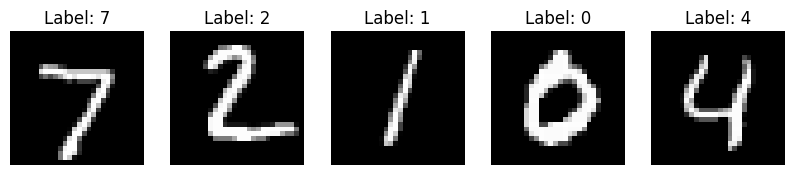

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')

plt.show()

In [42]:
## Abrir los modelos:

import os
loaded_local_models = [tf.keras.models.load_model(os.path.join(root, file)) for root, dirs, files in os.walk("../local_models") for file in files if file.endswith('.keras')]


# Federated averaging


FedAvg se trata de una técnica de optimización para el aprendizaje federado donde se promedian los pesos de los modelos locales para generar los pesos de predicción para el modelo global, como tal resulta como una técnica bastante eficiente en tiempo, dado que no se requiere un nuevo entrenamiento para generar el modelo final, no obstante, puede que resulte en un modelo sesgado en caso de que alguno de los modelos locales obtenga pesos muy diferentes a la media.

In [43]:
from src.modelG import build

local_weights = [x.get_weights() for x in loaded_local_models]
averaged_weights = [np.mean(np.array(weights), axis=0) for weights in zip(*local_weights)]

global_model = build.build_it()
global_model.set_weights(averaged_weights)

from sklearn.metrics import classification_report
y_pred = global_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

global_model.save('../global_models/global_modelFEDAVG.keras')


     


d:\claseCloud\federated-models\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.10      1.00      0.19      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# IDA (Inverse Distance Aggregation)

Es una metodología que calcula las distancias de los modelos locales al global (inicializado usando la función build) (en este caso se utiliza la euclidiana) y después de eso se calculan los pesos del modelo global usando la norma de la suma de las distancias inversas de los modelos locales. Se considera bueno dado que reduce el effecto de datos atípicos en el set de entrenamiento.

In [44]:
import numpy as np
from src.modelG import build

# Construir el modelo global
global_model = build.build_it()
global_weights = global_model.get_weights()

# Cargar los modelos locales
local_weights = [model.get_weights() for model in loaded_local_models]

# Función para calcular la distancia euclidiana entre dos conjuntos de pesos
def compute_distance(w1, w2):
    return np.sqrt(sum([np.sum((a - b) ** 2) for a, b in zip(w1, w2)]))

# Parámetro para la distancia
epsilon = 1e-10

# Calcular la distancia entre los pesos locales y los pesos globales
distances = [compute_distance(w, global_weights) for w in local_weights]

# Calcular los pesos inversos basados en la distancia
# y normalizarlos
inv_dist_weights = [1 / (d + epsilon) for d in distances]
weight_sum = sum(inv_dist_weights)
norm_weights = [w / weight_sum for w in inv_dist_weights]

# Realizar la agregación ponderada de los pesos locales
aggregated_weights = []
for layer_idx, layer_weights in enumerate(zip(*local_weights)):  
    weighted_sum = np.zeros_like(layer_weights[0])
    for client_idx, client_weights in enumerate(local_weights):
        weighted_sum += norm_weights[client_idx] * layer_weights[client_idx]
    aggregated_weights.append(weighted_sum)
    
# Actualizar el modelo global con los pesos agregados
global_model.set_weights(aggregated_weights)

# Evaluar el modelo global
y_pred = global_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes))

global_model.save('../global_models/global_modelIDA.keras')



d:\claseCloud\federated-models\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.10      1.00      0.19      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Federated stochastic gradient descent (FedSGD)


Esta técnica es parecida a FedAVG, solo que en lugar de utilizar la media de los pesos de los modelos locales, utiliza la media de los gradientes de los modelos locales para calcular el gradiente del optimizador del modelo global, como tal podría sufrir los mismos problemas de sesgo correspondientes a FedAVG

In [ ]:
import numpy as np
from src.modelG import build


global_model = build.build_it()

# Obtener los pesos de los modelos locales
grads_list = []

for local_model in range(len(loaded_local_models)):
    
    x_train = np.load(f'../data/x_train_fold_{local_model}.npy')
    y_train = np.load(f'../data/y_train_fold_{local_model}.npy')
    with tf.GradientTape() as tape:
        y_pred = loaded_local_models[local_model](x_train, training=True)
        loss = loaded_local_models[local_model].compiled_loss(y_train, y_pred)
    grads = tape.gradient(loss, loaded_local_models[local_model].trainable_variables)
    grads_list.append(grads)

# Promediar los gradientes
average_grads = []
for grads in zip(*grads_list):
    stacked = np.stack([g.numpy() for g in grads], axis=0)
    avg = np.mean(stacked, axis=0)
    average_grads.append(tf.convert_to_tensor(avg))

# Actualizar el modelo global con los gradientes promediados
optimizer = global_model.optimizer
optimizer.apply_gradients(zip(average_grads, global_model.trainable_variables))

# Predecir con el modelo global
y_pred = global_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes))

global_model.save('../global_models/global_modelFEDSGD.keras')


d:\claseCloud\federated-models\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\claseCloud\federated-models\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:665: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.10      1.00      0.18       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
